# **License Plate Detection using OpenCV2**

**Note** : The following program assumes the license plate have *black* characters on *white* background.

## **Importing Libraries**

1. **cv2** : Required for image preprocessing, masking and contour detection
2. **matplotlib** : for visualizing the images
3. **easyocr** : for Optical Character Recognition (OCR)
4. **numpy** : used for character segmentation
5. **os** : used for Operating System operations, like creating folders, saving files etc.

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import easyocr
import os

## **Cropping Region of Interest**
The following code allows user to crop the provided image, selecting the region around license plate. This increases the accuracy of contour detection in the subsequent steps

**Note** : The code may not run in jupyter notebook, due to its configuration setttings. Try executing the script separately as a Python Script.

In [ ]:
import cv2
import matplotlib.pyplot as plt

selected_roi = None
roi_selected = False


def select_roi(event, x, y, flags, param):
    global selected_roi, roi_selected

    if event == cv2.EVENT_LBUTTONDOWN:
        selected_roi = [(x, y)]
        roi_selected = False

    elif event == cv2.EVENT_LBUTTONUP:
        selected_roi.append((x, y))
        roi_selected = True
        cv2.rectangle(img, selected_roi[0], selected_roi[1], (0, 255, 0), 2)
        cv2.imshow('Select ROI', gray_img)
        print("Release the mouse to confirm the selection.")


#Image preprocessing
img = cv2.imread('/Users/saieshagre/Downloads/Test/sample14.JPG')
resized_img = cv2.resize(img, (800, 600))
gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)

if gray_img is None:
    print("Error: Unable to load the image.")
    exit()

clone = gray_img.copy()


cv2.namedWindow('Select ROI')
cv2.setMouseCallback('Select ROI', select_roi)


print("Click and drag to select a region containing the license plate.")
print("Press 'Esc' to cancel or 'Enter' to confirm the selection.")

while True:
    cv2.imshow('Select ROI', gray_img)
    key = cv2.waitKey(1) & 0xFF

    if roi_selected:
        break

    if key == 27:  # Press 'Esc' to exit
        print("Selection canceled.")
        cv2.destroyAllWindows()
        exit()


roi_x, roi_y = min(selected_roi[0][0], selected_roi[1][0]), min(selected_roi[0][1], selected_roi[1][1])
roi_w, roi_h = abs(selected_roi[0][0] - selected_roi[1][0]), abs(selected_roi[0][1] - selected_roi[1][1])
cropped_img = clone[roi_y:roi_y + roi_h, roi_x:roi_x + roi_w]
cv2.imwrite("/Users/saieshagre/Downloads/masked.jpg", cropped_img);

cv2.waitKey(0)
cv2.destroyAllWindows()


In [9]:
cropped_img = cv2.imread('/Users/saieshagre/Downloads/masked.jpg')
cropped_img = cv2.resize(cropped_img, (800, 400))
cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)

## **License Plate Extraction**

I have implemented 2 approaches to filter out potential regions of intertest in the image:
1. Thresholding
2. Edge Detection

These methods are implemented separately for this project, although they could be combined into a single approach. These methods are applied after the standard image processing steps of **rescaling** and **grayscaling**.

**Note** : Execute *only one* of the following methods

### 1. Thresholding

Thresholding in image processing involves converting an image into a binary form, where pixels are classified as either *foreground* or *background* based on a certain intensity threshold. Pixels with intensities below the threshold are set to one value (usually black), and those above the threshold are set to another value (usually white).

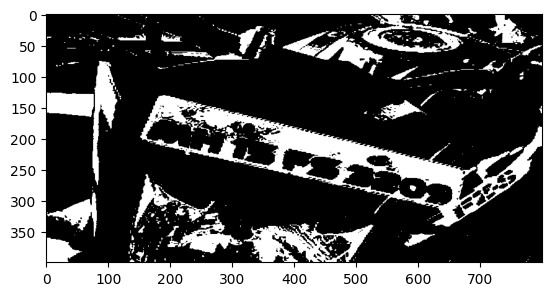

In [10]:
#blur = cv2.GaussianBlur(gray_image, (5, 5), 0) Blurring can be applied in some cases to enhance accuracy

# Threshold to extract white regions
_, thresholded = cv2.threshold(cropped_img, 180, 255, cv2.THRESH_BINARY)
plt.imshow(cv2.cvtColor(thresholded, cv2.COLOR_BGR2RGB))

### 2. Edge Detection (Canny Edge Detection)
Edge detection is a technique in image processing that aims to identify *boundaries* within an image where there is a *significant change in intensity*. It helps locate edges or boundaries of objects, making it useful for image segmentation and feature extraction. 

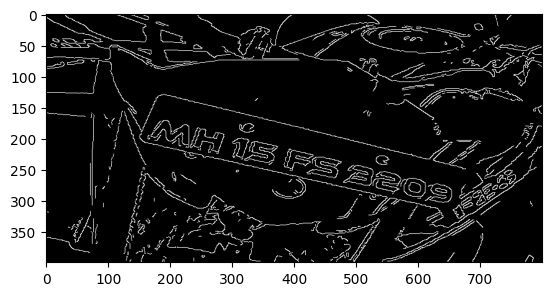

In [19]:
blur = cv2.GaussianBlur(cropped_img, (3, 3), 0)
edged = cv2.Canny(blur, 180, 255)
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

## **Contour Detection**

Contour detection in image processing involves identifying and extracting the boundaries of objects or regions within an image. After detecting edges, algorithms analyze the connectivity of these edge points to form contours, outlining distinct objects in the image.

In [11]:
contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) For Edge Detection method

contours = sorted(contours, key = cv2.contourArea, reverse = True)

rect = cv2.minAreaRect(contours[0])
box = cv2.boxPoints(rect).astype('int')

### Processing the obtained coordinates of contours, for perspective transformations.

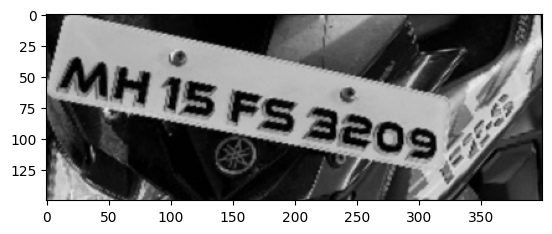

In [12]:
coordinates = np.array(box, dtype=np.float32).reshape(4, 2)

# Sort the whole array based on the first column
sorted_array = coordinates[coordinates[:, 0].argsort()]

# Sort the first two subarrays based on the second column
sorted_array[:2] = sorted_array[:2][np.argsort(-sorted_array[:2, 1])]

# Sort the last two subarrays based on the second column
sorted_array[2:] = sorted_array[2:][np.argsort(-sorted_array[2:, 1])]

# Define the target rectangle for the extracted plate
plate_width, plate_height = 400, 150
target_plate_coordinates = np.array([[0, plate_height - 1], [0, 0], [plate_width - 1, plate_height - 1],
[plate_width - 1, 0]], dtype=np.float32)

# Calculate the perspective transform matrix
matrix = cv2.getPerspectiveTransform(sorted_array, target_plate_coordinates)

# Apply the perspective transform to extract the plate
ROI = cv2.warpPerspective(cropped_img, matrix, (plate_width, plate_height))

plt.imshow(cv2.cvtColor(ROI, cv2.COLOR_BGR2RGB))

### Applying Bilateral filter to enhance clarity of extracted Region of Interest (Optional)

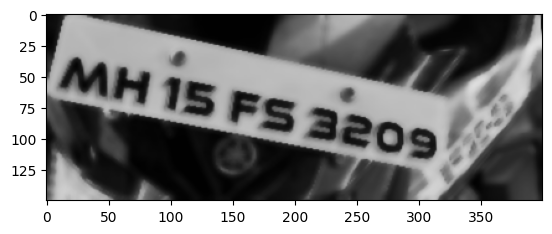

In [13]:
enhanced_plate = cv2.bilateralFilter(ROI, 9, 75, 75)
plt.imshow(cv2.cvtColor(enhanced_plate, cv2.COLOR_BGR2RGB))

# **EasyOCR**

In [ ]:
reader = easyocr.Reader(['en'])
result = reader.readtext(ROI)
result

## **Character Segmentation**
The following code inputs the license plate region extracted from the previous steps to split into individual characters.

**Intuition** : We take the *sum of intensities* of each column in the image, and we select the *maximum sum*. Then for segementation, the columns with a sum *greater than* the *threshold* (in this case 0.05 of maximum sum) is considered as thecolumn of a *potential* character.

**Note** : May not work as expected due to various real world variations and complexities. The algorithm applied uses a naive approach

In [18]:
def vertical_split(binary_image):
    # Apply vertical projection
    projection = np.sum(binary_image, axis=0)

    # Threshold the projection to find potential split columns
    threshold = 0.05 * np.max(projection)
    split_columns = np.where(projection > threshold)[0]

    # Create a mask for split columns
    mask = np.zeros_like(binary_image)
    mask[:, split_columns] = 255

    # Perform Connected Component Analysis (CCA)
    _, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=4)

    # Extract characters based on CCA bounding rectangles
    characters = []
    for stat in stats[1:]:
        x, y, w, h = stat[:4]
        if w > 10:
          character = binary_image[:, x:x+w]
          characters.append(character)

    return characters

def save_characters(characters, output_folder='output'):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Save each character as an image file
    for i, char in enumerate(characters):
        cv2.imwrite(os.path.join(output_folder, f'char_{i}.png'), char)


# Apply adaptive thresholding with Gaussian mean
binary_image = cv2.adaptiveThreshold(
        enhanced_plate, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 21, 10
)

# Perform vertical split using Connected Component Analysis
characters = vertical_split(binary_image)

# Save characters
save_characters(characters, output_folder='output')